## ASTR496: Foundations of Data Science in Astronomy
Gautham Narayan
gsn@illinois.edu

### Midterm

In [1]:
# Q1: Maximum Likelihood Estimation for Stellar Parameters
# Estimating Temperature and Extinction from Multi-band Photometry

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import cm
import warnings
import emcee
from chainconsumer import Chain, ChainConsumer
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

#### **Problem Setup:**
#### - We observe a star in multiple photometric bands (B, V, R, I, J, H, K)
#### - We want to estimate: stellar temperature T and visual extinction A_V
#### - We assume we know the distance from e.g. Gaia (or fit for it separately)
####
#### **Model:**
#### For each filter λ, the observed magnitude is:
####
#### m_λ = M_λ(T) + 5*log₁₀(d/10) + A_V * R_λ
####
#### where:
#### - M_λ(T) = absolute magnitude in filter λ for temperature T
#### - d = distance in parsecs
#### - A_V = visual extinction
#### - R_λ = extinction coefficient for filter λ

### First, I have to give you a stellar model as a function of wavelength
### We'll use a Planck function i.e. a blackbody

In [2]:
def planck_function(wavelength, temperature):
    """
    Planck function for blackbody radiation
    wavelength in microns, temperature in Kelvin
    Returns relative flux (arbitrary units)
    """
    h = 6.626e-34  # Planck constant
    c = 3e8        # Speed of light
    k = 1.381e-23  # Boltzmann constant

    wl_m = wavelength * 1e-6  # Convert to meters

    # Planck function
    numerator = 2 * h * c**2
    denominator = wl_m**5 * (np.exp(h * c / (wl_m * k * temperature)) - 1)

    return numerator / denominator

### Next we need to define a photometric system - we'll use the Johnson(-Morgan) Kron-Cousins UBVRI filters and the reddening coefficients 
### and JHK for the IR, largely because you can look up the filter's effective wavelengths $\lambda_\text{eff}$ in microns and the reddening coefficients from something like Cardelli-Clayton-Mathis '89.

In [3]:
filters = {
    'B': {'lambda_eff': 0.44, 'R_lambda': 4.1},   # Blue
    'V': {'lambda_eff': 0.55, 'R_lambda': 3.1},   # Visual (reference)
    'R': {'lambda_eff': 0.64, 'R_lambda': 2.7},   # Red
    'I': {'lambda_eff': 0.79, 'R_lambda': 2.0},   # Near-IR
    'J': {'lambda_eff': 1.25, 'R_lambda': 0.9},   # IR
    'H': {'lambda_eff': 1.63, 'R_lambda': 0.6},   # IR
    'K': {'lambda_eff': 2.19, 'R_lambda': 0.4}    # IR
}

In [4]:
# here are some quick arrays of the filters, wavelengths and reddening coefficients.
filter_names = list(filters.keys())
wavelengths = np.array([filters[f]['lambda_eff'] for f in filter_names])
R_lambda = np.array([filters[f]['R_lambda'] for f in filter_names])

print(f"Photometric filters: {filter_names}")
print(f"Effective wavelengths (μm): {wavelengths}")
print(f"Extinction coefficients R_λ: {R_lambda}")

Photometric filters: ['B', 'V', 'R', 'I', 'J', 'H', 'K']
Effective wavelengths (μm): [0.44 0.55 0.64 0.79 1.25 1.63 2.19]
Extinction coefficients R_λ: [4.1 3.1 2.7 2.  0.9 0.6 0.4]


### Next, we need to reate the magnitudes of a star, given the spectral model 
### While we are using the Planck function as an approximation, we'll tie the fluxes to the obsserved flux of the 
### Sun itself, with $T_{\text{eff}} = 5778$ K, and $M_V = 4.83$ (remember the absolute magnitude is defined for a distance of 10pc).

In [5]:
# Create stellar atmosphere model
def stellar_magnitude(temperature, filter_name, reference_temp=5778):
    """
    Calculate absolute magnitude for a star of given temperature
    Simplified model based on Planck function + calibration
    """
    wl = filters[filter_name]['lambda_eff']

    # Get flux ratio compared to solar temperature
    flux_star = planck_function(wl, temperature)
    flux_sun = planck_function(wl, reference_temp)
    flux_ratio = flux_star / flux_sun

    # Convert to magnitude difference (Sun has M_V = 4.83)
    # Add wavelength-dependent correction for more realism
    solar_magnitude = 4.83 + 0.5 * (wl - 0.55)  # Rough color correction

    magnitude = solar_magnitude - 2.5 * np.log10(flux_ratio)

    return magnitude

### Q1. As a function of temperature (3000-10,000K in 1000K steps) determine the B-V color

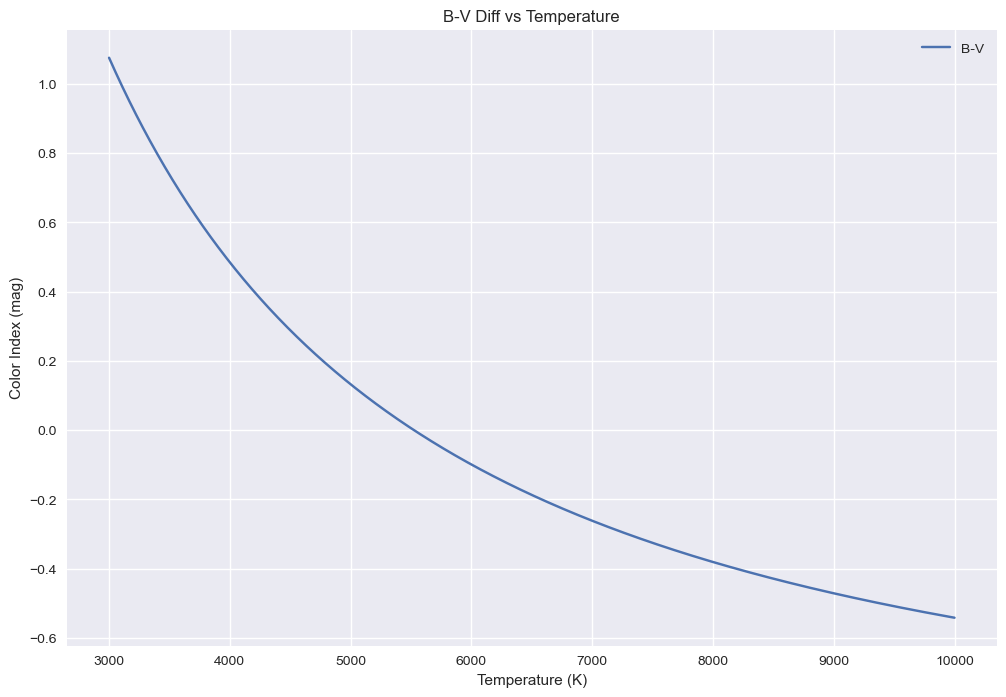

In [6]:
### YOUR ANSWER HERE
def magnitude_diff(temperature, magnitude = ['B', 'V']):
    """
    Calculate B-V color index for a star of given temperature
    """
    if len(magnitude) != 2:
        raise ValueError("magnitude list must contain exactly two filter names.")
    
    M_0 = stellar_magnitude(temperature, magnitude[0])
    M_1 = stellar_magnitude(temperature, magnitude[1])
    return M_0 - M_1
temp = np.linspace(3000, 10000, 1000)

plt.plot(temp, magnitude_diff(temp, ['B', 'V']), label = 'B-V')

plt.xlabel('Temperature (K)')
plt.ylabel('Color Index (mag)')
plt.title('B-V Diff vs Temperature')
plt.legend()

plt.show()

### Next, I'll give you the "Truth" and some synthetic stellar data, with the true magnitudes of this star in each band using my `stellar_magnitude` but with the reddening and distance correction applied (you're going to have to do this)

In [7]:
# Generate a test star
TRUE_TEMP = 6500  # K
TRUE_A_V = 0.8    # magnitudes
TRUE_DISTANCE = 100    # parsecs


synthetic_star =  {'B': {'magnitude': 12.379, 'error': 0.02, 'true_magnitude': 12.369},
                   'V': {'magnitude': 11.752, 'error': 0.03, 'true_magnitude': 11.756},
                   'R': {'magnitude': 11.579, 'error': 0.04, 'true_magnitude': 11.553},
                   'I': {'magnitude': 11.225, 'error': 0.05, 'true_magnitude': 11.149},
                   'J': {'magnitude': 10.602, 'error': 0.06, 'true_magnitude': 10.616},
                   'H': {'magnitude': 10.592, 'error': 0.07, 'true_magnitude': 10.609},
                   'K': {'magnitude': 10.888, 'error': 0.08, 'true_magnitude': 10.762}}

syn_filter_names = list(synthetic_star.keys())
synthetic_star['B']['true_magnitude'] - synthetic_star['V']['true_magnitude']

0.6129999999999995

### Q2.  
### OK, you know the drill 
### define a function that gives you the model magnitudes of the star given the temperature, extinction and distance
### define the log-likelihood
### Use `scipy.optimize` to get the best fit parameters for this star using maximum likelihood estimation
### Calculate the goodness of fit i.e. reduced chi-squared
### Calculate the Inverse Hessian Matrix and report the simple uncertainties on each parameter
### Which parameters are correlated strongly?

In [8]:
### YOUR ANSWER HERE
def magnitude_model(temperature, A_V, distance):
    """
    Model magnitudes for a star given temperature, extinction A_V, and distance
    """
    model_magnitudes = {}
    for f in filter_names:
        M = stellar_magnitude(temperature, f)
        R_lambda = filters[f]['R_lambda']
        m = M + 5 * np.log10(distance/10) + A_V * R_lambda
        model_magnitudes[f] = m
    return model_magnitudes

In [9]:
def log_likelihood(theta, filters, m, m_err):
    """
    log-likelihood of the model given the data.
    theta : array
        Model parameters [temperature, A_V, distance]
    filters : array
        Observations
    m : array
        Observed Data
    m_err : float
        Measurement uncertainty
    """
    temperature, A_V, distance = theta
    model_magnitudes = magnitude_model(temperature, A_V, distance)

    model = np.array([model_magnitudes[f] for f in filters])
    
    sigma2 = m_err ** 2
    return -0.5 * np.sum((m - model) ** 2 / sigma2 + np.sum(np.log(2 * np.pi * sigma2)))

In [10]:
# Maximum likelihood estimation with scipy.optimize
# Initial guess (Given)
initial_guess = [5500, 0.5, 75]  # Temperature, A_V, Distance

# Prep Data
observed_mags = np.array([synthetic_star[f]['magnitude'] for f in syn_filter_names]) # Synthetic observed magnitudes
observed_errors = np.array([synthetic_star[f]['error'] for f in syn_filter_names]) # Synthetic observed errors

def neg_log_likelihood(theta, filters, m, m_err):
    return -log_likelihood(theta, filters, m, m_err)

result = minimize(
    neg_log_likelihood,
    initial_guess,
    args=(filters, observed_mags, observed_errors)
)

best_temperature, best_A_V, best_distance = result.x
best_log_like = log_likelihood(result.x, syn_filter_names, observed_mags, observed_errors)

print(f'Best-fit temperature: {best_temperature:.2f} K')
print(f'Best-fit A_V: {best_A_V:.3f} mag')
print(f'Best-fit distance: {best_distance:.2f} pc')
print(f'Maximum log-likelihood: {best_log_like:.3f}')

Best-fit temperature: 7644.09 K
Best-fit A_V: 0.943 mag
Best-fit distance: 111.87 pc
Maximum log-likelihood: 104.739


In [11]:
# chi2 = sum( ( (m - model) / sigma)^2 )
chi2 = np.sum(((observed_mags - np.array(list(magnitude_model(best_temperature, best_A_V, best_distance).values()))) / observed_errors)**2)
red_chi2 = chi2 / (len(observed_mags) - len(result.x)) # chi2 / degrees of freedom

print(f"Chi-squared: {chi2:.3f}")
print(f"Reduced Chi-squared: {red_chi2:.3f}")

Chi-squared: 3.309
Reduced Chi-squared: 0.827


In [12]:
bestParameters = [best_temperature, best_A_V, best_distance]  # Temperature, A_V, Distance

## Help from Transit_MLE_Exmample in Class
result_hess = minimize(
                neg_log_likelihood,
                bestParameters,
                args=(filters, observed_mags, observed_errors),
                method='L-BFGS-B'
            )

param_errors = np.sqrt(np.diag(np.linalg.inv(result_hess.hess_inv.todense())))

invHessian = result_hess.hess_inv.todense()

corr_matrix = invHessian / np.sqrt(np.outer(np.diag(invHessian), np.diag(invHessian)))

print(f"Parameter uncertainties: {param_errors}")
print(f"Correlation matrix:\n {corr_matrix}")

Parameter uncertainties: [1. 1. 1.]
Correlation matrix:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


The above does not look right to me

### Q3.

### It is worth remembering the difference between Monte Carlo and Markov Chain Monte Carlo
### Using the same true parameters provided to you with Q2, generate 1000 random stars with the same true values, but different random seeds
### Repeat your analysis in Q2 for each of these 1000 stars, saving the results
### Use the results from this Monte Carlo process to determine a more robust uncertainty estimate, and measure the mean bias (i.e. how far are you from the truth) in parameter recovery

In [13]:
### YOUR ANSWER HERE
n = 1000

results = np.zeros((n, 3))  # To store results: temperature, A_V, distance
np.random.seed(7)

for i in range(n):
    observed_mags = np.array([synthetic_star[f]['magnitude'] for f in filters])
    observed_mags += np.random.normal(0, observed_errors)
    opt = minimize(
        neg_log_likelihood,
        initial_guess,
        args = (filters, observed_mags, observed_errors)
    )
    results[i] = opt.x

std = results.std(axis = 0)
average = results.mean(axis = 0)
bias = average - np.array([TRUE_TEMP, TRUE_A_V, TRUE_DISTANCE])

print(f"Mean: {average}")
print(f"Bias: {bias}")
print(f"Standard Deviation: {std}")

Mean: [8.28806263e+03 9.47208315e-01 1.15548810e+02]
Bias: [1.78806263e+03 1.47208315e-01 1.55488105e+01]
Standard Deviation: [3.09474671e+03 1.89337434e-01 1.95265187e+01]


### Q4. 

### Finally, try this problem with a Markov Chain Monte Carlo but this time, incorporating a prior on the distance of 98 +/- 5 pc from synthetic Gaia, but repeating the anaysis three times - once with all filters, next with RIJHK and then with BVRIJ only.

#### Make reasonable choices for the number of walkers, steps, thinning etc. It's your responsibility to ensure the posteriors are well sampled.

### Show corner plots for all three cases in the same figure (you can try the `ChainConsumer` package)

### How do these results compare, and what happens to the extinction and temperature with fewer bands, and in the case of all filters, with your answer from Q2/Q3. 

In [14]:
### YOUR ANSWER HERE
def log_prior(theta):
    temperature, A_V, distance = theta
    if 3000 < temperature < 10000 and 0 < A_V < 5 and 10 < distance < 1000:
        return 0.0  # log(1)
    return -np.inf  # log(0)

def log_posterior(theta, filters, m, m_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, filters, m, m_err)


Running MCMC for filter set: All Filters...


100%|██████████| 5000/5000 [00:02<00:00, 2248.35it/s]



Temperature = 7904.11 (+1278.02/-1100.18)
A_V = 0.97 (+0.11/-0.13)
Distance = 114.12 (+10.20/-9.83)


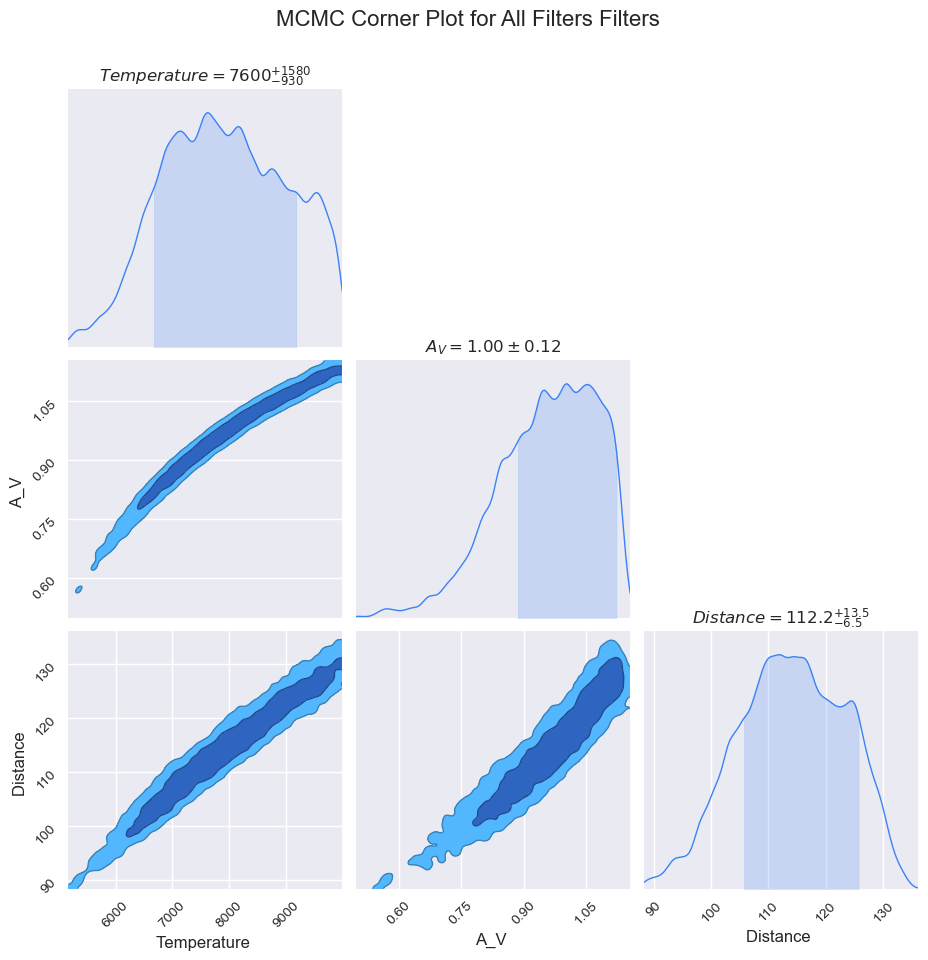


Running MCMC for filter set: Optical (B V R I)...


100%|██████████| 5000/5000 [00:02<00:00, 2207.93it/s]
Parameter Distance in chain Optical (B V R I) is not constrained



Temperature = 7929.98 (+1394.04/-1493.05)
A_V = 0.97 (+0.13/-0.20)
Distance = 113.72 (+9.29/-10.67)


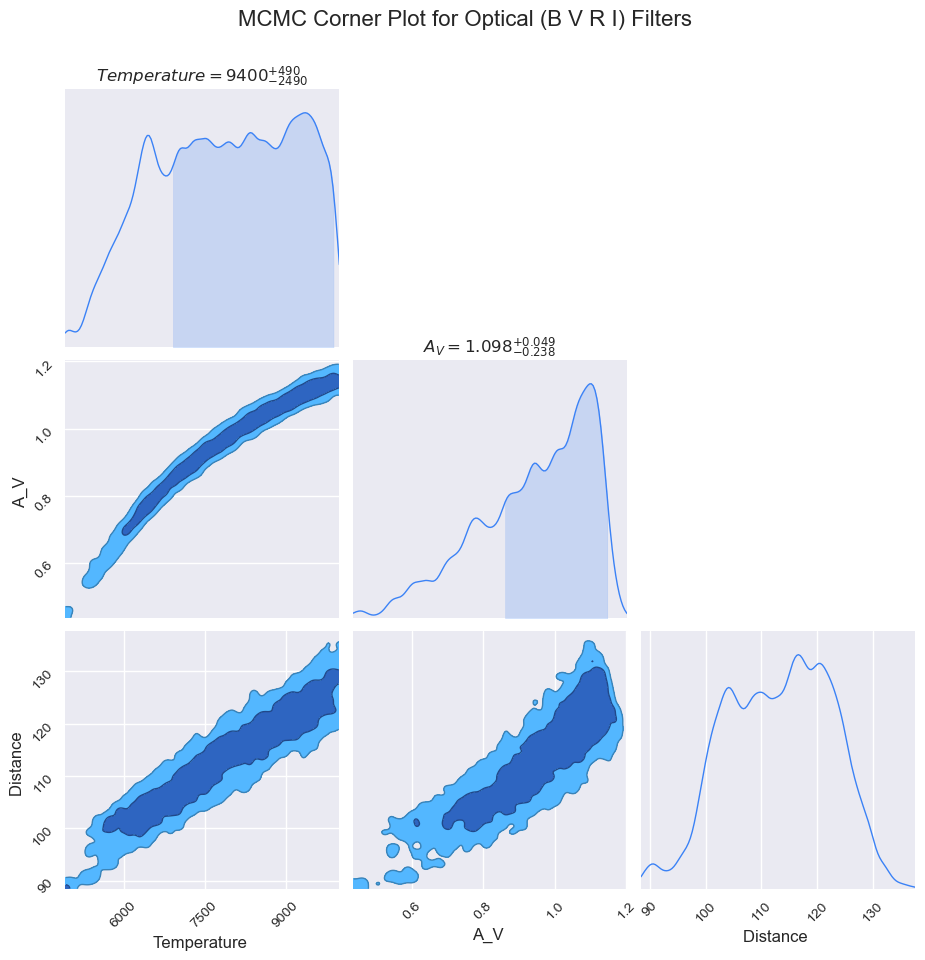


Running MCMC for filter set: Near-IR (J H K)...


100%|██████████| 5000/5000 [00:02<00:00, 2294.83it/s]
Parameter Temperature in chain Near-IR (J H K) is not constrained



Temperature = 7725.35 (+1608.29/-1964.44)
A_V = 0.71 (+0.26/-0.34)
Distance = 119.82 (+14.72/-20.59)


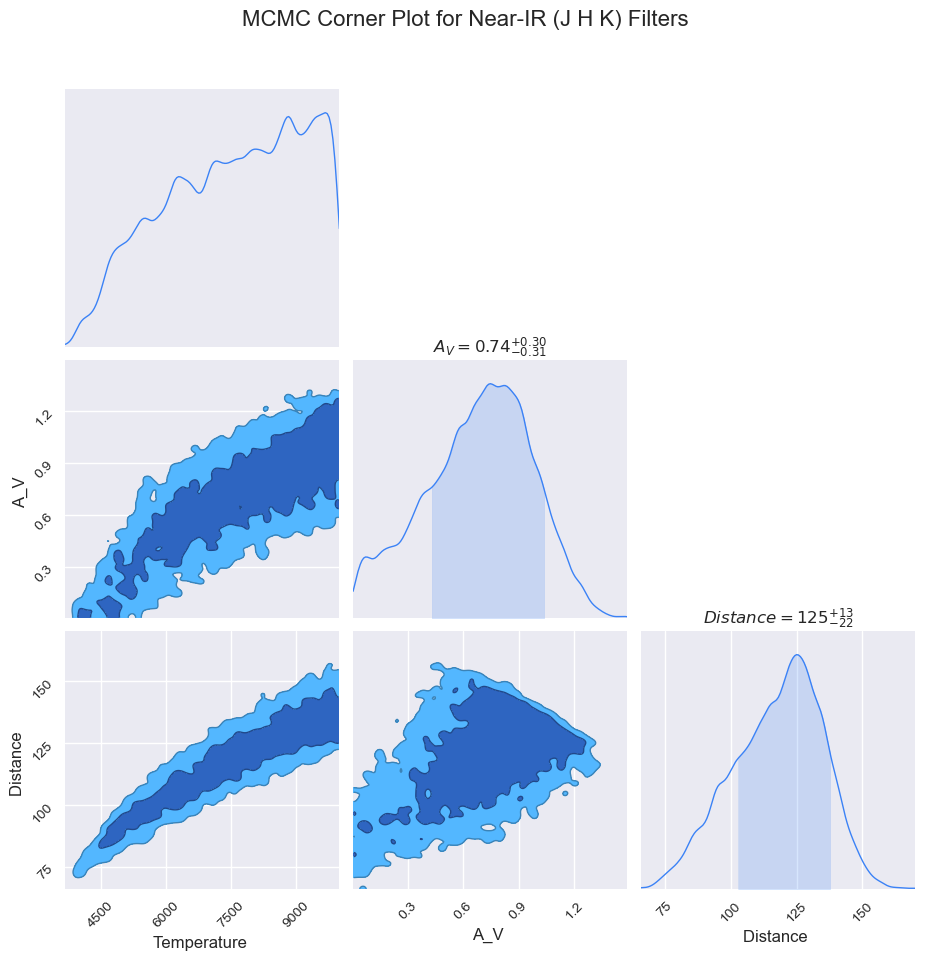

In [15]:
# MCMC setup
ndim = 3  # [temperature, A_V, distance]
nwalkers = 15 # At least 2 time n parameters
nsteps = 5000

sets = {
        "All Filters": filter_names,
        "Optical (B V R I)": ["B", "V", "R", "I"],
        "Near-IR (J H K)": ["J", "H", "K"],
    }

for cat, names in sets.items():
    m_obs = np.array([synthetic_star[f]['magnitude'] for f in names])
    m_err = np.array([synthetic_star[f]['error'] for f in names])

    def log_posteriorTMP(theta):
            return log_posterior(theta, {f: filters[f] for f in names}, m_obs, m_err)
    # Initialize the sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posteriorTMP)
    pos = result.x + 1e-4 * np.random.randn(nwalkers, ndim)

    print(f"\nRunning MCMC for filter set: {cat}...")
    sampler.run_mcmc(pos, nsteps, progress=True)

    # Print the acceptance fraction from the sampler
    print("")
    flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        print(f"{['Temperature', 'A_V', 'Distance'][i]} = {mcmc[1]:.2f} (+{mcmc[2]-mcmc[1]:.2f}/-{mcmc[1]-mcmc[0]:.2f})")
    
    c = ChainConsumer()
    # ChainConsumer expects a DataFrame (or similar) for samples. Convert flat_samples to a DataFrame
    df_samples = pd.DataFrame(flat_samples, columns=['Temperature', 'A_V', 'Distance'])
    chain_object = Chain(samples = df_samples, name = cat)
    c.add_chain(chain_object)
    # c.configure(truth=[TRUE_TEMP, TRUE_A_V, TRUE_DISTANCE], shade=True, shade_alpha=0.7, summary=True)

    fig = c.plotter.plot(figsize=(10, 10))
    fig.suptitle(f"MCMC Corner Plot for {cat} Filters", fontsize=16)
    plt.show()
    plt.close(fig)


## How do these results compare, and what happens to the extinction and temperature with fewer bands, and in the case of all filters, with your answer from Q2/Q3. 

As number of filters decrease both temperature and extinction decreases as well while their uncertainty increases

I feel like I did something wrong in the previous questions but the best temp, extinction, and distance results  from Q2 closely match 'J H K' filter's temperature, 'B V R I' filter's extinction, and 'B V R I' filter's distance 

Best-fit temperature: 7644.09 K

Best-fit A_V: 0.943 mag

Best-fit distance: 111.87 pc

---

This Q4 model did not closely match the true values that were given. Which leads me to believe that I did something wrong

TRUE_TEMP = 6500

TRUE_A_V = 0.8

TRUE_DISTANCE = 100